# Logistic Regression

**Basic Description**
- Logistic regression is one of the simplest and most popular classification algorithms
- In logistic regression, a linear output is converted into a probability between 0 and 1 using the sigmoid function
- Logistic regression is highly interprettable and easier to explain than other models

**Bias-Variance Tradeoff** 
- Its simplicity makes for high bias and low variance

**Upsides**
- It's quick to implement and can serve as a good baseline for performance

**Downsides**
- It generally does not perform well with non-linear decision boundaries

**Other Notes**
- When interprettability is desireable, it's important that features are not correlated

## Load Packages and Prep Data

In [31]:
# custom utils
from utils import custom
from utils.cf_matrix import make_confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.metrics import confusion_matrix



In [4]:
LogisticRegression?

Init signature:
LogisticRegression(
    penalty='l2',
    *,
    dual=False,
    tol=0.0001,
    C=1.0,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='lbfgs',
    max_iter=100,
    multi_class='auto',
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=None,
)
Docstring:     
Logistic Regression (aka logit, MaxEnt) classifier.

In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
scheme if the 'multi_class' option is set to 'ovr', and uses the
cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
(Currently the 'multinomial' option is supported only by the 'lbfgs',
'sag', 'saga' and 'newton-cg' solvers.)

This class implements regularized logistic regression using the
'liblinear' library, 'newton-cg', 'sag', 'saga' and 'lbfgs' solvers. **Note
that regularization is applied by default**. It can handle both dense
and sparse input. Use C-ordered arrays or CSR matrices containi

In [5]:
# load data
X_train, y_train, X_test, y_test = custom.load_data()

X_train (62889, 42)
y_train (62889,)
X_test (15723, 42)
y_test (15723,)


## Model 1
- Default hyperparameters
    - Except `max_iter=200`, not converging within default 100
- Notable
    - L2-norm cost `penalty='l2'`
    - No regularization `C=1.0`

### Fit Model

In [6]:
# fit logistic regression model
log_1 = LogisticRegression(max_iter=200)
x = log_1.fit(X_train, y_train)

### Cross validation

In [7]:
# cross-validation scoring
log_1_scores = custom.cv_metrics(log_1, X_train, y_train)
log_1_scores

accuracy     0.951
precision    0.784
recall       0.369
f1           0.502
dtype: float64

## Model 2
- Regularize by selecting important features from recursive feature elimination ranking

### Feature Selection

In [8]:
# recursive feature elimination to determine feature importance
log = LogisticRegression(max_iter = 200)
model_rfe = RFECV(log, cv = 5)
x = model_rfe.fit(X_train, y_train)

In [9]:
# feature ranking
rfe = model_rfe.ranking_
features = X_train.columns
rfe_df = pd.DataFrame({'features': features, 'rfe_rank': rfe})
rfe_df.sort_values(by = 'rfe_rank', ascending = True)

,features,rfe_rank
20,solidity,1
36,fiber_width,1
35,fiber_length,1
34,ellipticity,1
33,angularity,1
30,t_w_ratio,1
29,w_t_ratio,1
27,l_w_ratio,1
25,curvature,1
24,transparency,1


In [10]:
# features ranked 1 are the most important
# select only the more important features as a means of regularization
selected_features = rfe_df[rfe_df['rfe_rank'] == 1]['features'].values
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [11]:
# 16 important features
X_train_selected.shape

(62889, 16)

### Fit Model

In [12]:
# fit logistic regression model
# using max_iter 400 to avoid error message
# using X_train_new to select only the 16 features that were selected
log_2 = LogisticRegression(max_iter = 400)
x = log_2.fit(X_train_selected, y_train)

### Cross validation

In [13]:
# cross-validation scoring
log_2_scores = custom.cv_metrics(log_2, X_train, y_train)
log_2_scores

accuracy     0.951
precision    0.784
recall       0.369
f1           0.502
dtype: float64

## Model 3
- Use grid search to tune regularization strength parameter `C`

### Fit Model

In [47]:
# define grid to search
param_grid={
        'C':np.arange(0.9,1.0,0.01)
}

# instance
gs = GridSearchCV(LogisticRegression(max_iter=200)
                ,param_grid
                ,cv=5
                ,n_jobs=-1
                #,verbose=1
    )

# search and fit
gs.fit(X_train, y_train)

# best params and score
print(gs.best_params_)
print(gs.best_score_)

# store best model
log_3 = gs.best_estimator_

{'C': 0.9800000000000001}
0.9508817081277658


### Cross-Validation

In [48]:
# cross-validation scoring
log_3_scores = custom.cv_metrics(log_3, X_train, y_train)
log_3_scores

accuracy     0.951
precision    0.784
recall       0.369
f1           0.501
dtype: float64

## Model 4
- Account for imbalance in training data
- Adjust class weights to favor minority class detection
- Reference: https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_6_ImbalancedLearning/Introduction.html

### Class Weighting

In [16]:
# imbalance
y_train.value_counts()

# compute ratio
imbalance_ratio = y_train.value_counts()[1] / y_train.value_counts()[0]
print(imbalance_ratio.round(3))

0.072


In [17]:
# adjusted weight by trial and error
majority_weight = imbalance_ratio*5
print(majority_weight.round(3))

# underweight the majority class (0)
class_weight={0:majority_weight,1:1}

0.359


### Fit

In [35]:
# fit logistic regression model
log_4 = LogisticRegression(max_iter = 300, class_weight=class_weight)
x = log_4.fit(X_train, y_train)

In [36]:
# cross-validation scoring
log_4_scores = custom.cv_metrics(log_4, X_train, y_train)
log_4_scores

accuracy     0.949
precision    0.627
recall       0.578
f1           0.602
dtype: float64

## Compare Default and Weighted
- The weighted cost model achieves a 20% improvement in F1 score. Recall is improved 57% while reducing precision only 20%.

In [20]:
model_comparison = pd.DataFrame(data = {'log_1':log_1_scores
                                        ,'log_4':log_4_scores})

model_comparison

,log_1,log_4
accuracy,0.951,0.949
precision,0.784,0.627
recall,0.369,0.578
f1,0.502,0.602


In [24]:
model_comparison['log_4'] / model_comparison['log_1'] - 1

accuracy    -0.002103
precision   -0.200255
recall       0.566396
f1           0.199203
dtype: float64

## Test Performance
- The best logistic regression model is chosen according to the cross-validation scores. Final validation scores are then computed using the test set. These scores will be used to compare amongst the other model classes.

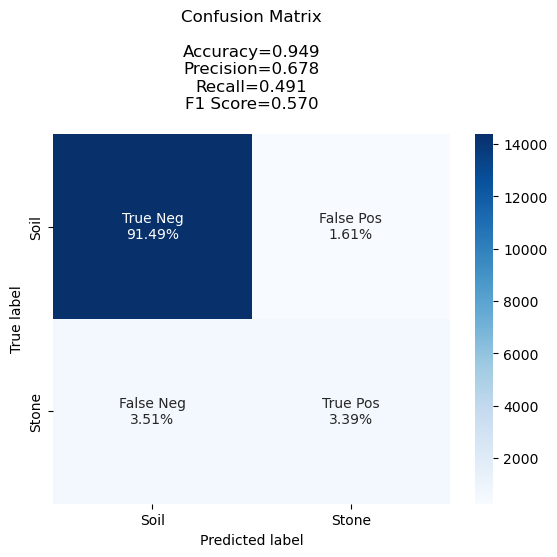

In [21]:
# test the performance of the selected model
y_pred = log_4.predict(X_test)
# pred_metrics(y_test, y_pred)

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Soil', 'Stone']
make_confusion_matrix(cm
                      ,group_names=labels
                      ,categories=categories
                      ,cmap='Blues'
                      ,count=False
                      )